<a href="https://colab.research.google.com/github/Joycechidi/Deep-Learning-/blob/master/Encrypted_Deep_Learning_Classification_on_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Encrpted Deep Learning Classification With PyTorch and PySyft on CIFAR-10 Dataset**

In this project, 


*   I will show how to use a private and secure neural network to classify CIFAR10 images which involves using the private additive sharing tool in the Secure Multi-Party Computation (SMPC method). There are other encryption methods such as Homomorphic Encryption (FHE/SHE) and Functional Encryption but I will use the SMPC method for this project.
*   I will encrypt both the model and the data in a way which allows one business to use a model owned by another business without either disclosing their IP to one another.

Dataset has 10 label classes:
										
1.   airplane
2.   automobile
3.   bird										
4.   cat										
5.   deer										
6.   dog										
7.   frog										
8.   horse										
9.   ship										
10. truck

This technique is important for businesses that create and collect data for building and training machine learning models which can be used by other other organizations. Data privacy is the drive force for using this technique so that other businesses who are not able to create or train their own model can use the existing machine learning services tailored for their industry or product without fear of data breach or privacy leakage.

Let's dive right into the project.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Import Libraries and Model Specifications**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [20]:
!pip install syft

Create some workers for the project and a secure crypto worker.


In [21]:
import syft as sy
hook = sy.TorchHook(torch) 
client = sy.VirtualWorker(hook, id="client")
ify = sy.VirtualWorker(hook, id="ify")
dandon = sy.VirtualWorker(hook, id="dandon")
chy = sy.VirtualWorker(hook, id="chy")
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider") 

W0819 04:03:25.560756 140264100607872 hook.py:98] Torch was already hooked... skipping hooking process


## **Define the Model Learning Parameters**

In [0]:
class NetArguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 200
        self.epochs = 10
        self.lr = 0.001 # learning rate
        self.log_interval = 100

args = NetArguments()

## **Data Loading and Sending Data to Workers**

In [23]:
#Let me se what is in this datasets module to be sure of how to call the cifar10 dataset. 
dir(datasets)
#perfect. Result shows I should call the dataset as CIFAR10

['CIFAR10',
 'CIFAR100',
 'Caltech101',
 'Caltech256',
 'CelebA',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'DatasetFolder',
 'EMNIST',
 'FakeData',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'ImageFolder',
 'ImageNet',
 'KMNIST',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Omniglot',
 'PhotoTour',
 'SBDataset',
 'SBU',
 'SEMEION',
 'STL10',
 'SVHN',
 'VOCDetection',
 'VOCSegmentation',
 'VisionDataset',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'caltech',
 'celeba',
 'cifar',
 'cityscapes',
 'coco',
 'fakedata',
 'flickr',
 'folder',
 'imagenet',
 'lsun',
 'mnist',
 'omniglot',
 'phototour',
 'sbd',
 'sbu',
 'semeion',
 'stl10',
 'svhn',
 'utils',
 'vision',
 'voc']

Loading the train data for training.

In [24]:
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=True, download=True,
                                                           transform=transforms.Compose([
                                                               transforms.ToTensor(),
                                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                           ])),
                                           batch_size=args.batch_size, shuffle=True)

Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## **Let's Visualize Some Training Images**

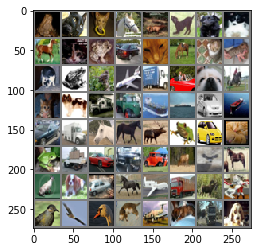

 frog   cat   dog horse


In [26]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Load Test Data for Predictions 

In [0]:
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, shuffle=False)

# Convert to integers and privately share the dataset
private_test_loader = []
for data, target in test_loader:
    private_test_loader.append((
        data.fix_prec().share(ify, dandon, chy, crypto_provider=crypto_provider),
        target.fix_prec().share(ify, dandon, chy, crypto_provider=crypto_provider)
    ))

## Define Network Architecture

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Classifier()

## **Train the Model**

In [0]:
def train(args, model, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        output = F.log_softmax(output, dim=1)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size,
                100. * batch_idx / len(train_loader)))

In [31]:
model = Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

for epoch in range(1, args.epochs + 1):
    train(args, model, train_loader, optimizer, epoch)
    


Train Epoch: 1 [0/50048 (0%)]
Train Epoch: 1 [6400/50048 (13%)]
Train Epoch: 1 [12800/50048 (26%)]
Train Epoch: 1 [19200/50048 (38%)]
Train Epoch: 1 [25600/50048 (51%)]
Train Epoch: 1 [32000/50048 (64%)]
Train Epoch: 1 [38400/50048 (77%)]
Train Epoch: 1 [44800/50048 (90%)]
Train Epoch: 2 [0/50048 (0%)]
Train Epoch: 2 [6400/50048 (13%)]
Train Epoch: 2 [12800/50048 (26%)]
Train Epoch: 2 [19200/50048 (38%)]
Train Epoch: 2 [25600/50048 (51%)]
Train Epoch: 2 [32000/50048 (64%)]
Train Epoch: 2 [38400/50048 (77%)]
Train Epoch: 2 [44800/50048 (90%)]
Train Epoch: 3 [0/50048 (0%)]
Train Epoch: 3 [6400/50048 (13%)]
Train Epoch: 3 [12800/50048 (26%)]
Train Epoch: 3 [19200/50048 (38%)]
Train Epoch: 3 [25600/50048 (51%)]
Train Epoch: 3 [32000/50048 (64%)]
Train Epoch: 3 [38400/50048 (77%)]
Train Epoch: 3 [44800/50048 (90%)]
Train Epoch: 4 [0/50048 (0%)]
Train Epoch: 4 [6400/50048 (13%)]
Train Epoch: 4 [12800/50048 (26%)]
Train Epoch: 4 [19200/50048 (38%)]
Train Epoch: 4 [25600/50048 (51%)]
Train Epo

## **Evaluate the Model Securely**

We are assuming that the model contains sensitive information which we have carefully optimized, so we don't want to disclose the model's weight. We need to secretly share the model as the client did with the test dataset.

In [32]:
model.fix_precision().share(ify, dandon, chy, crypto_provider=crypto_provider)

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

The next test function will perform encrypted evaluation where the model's weights, data inputs, the prediction and the target used for scoring are all encrypted.

In [0]:
def test(args, model, test_loader):
    model.eval()
    n_correct_priv = 0
    n_total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1) 
            n_correct_priv += pred.eq(target.view_as(pred)).sum()
            n_total += args.test_batch_size
            
            n_correct = n_correct_priv.copy().get().float_precision().long().item()
    
            print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
                n_correct, n_total,
                100. * n_correct / n_total))

In [0]:
test(args, model, private_test_loader)